In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
g_palette = glasbey.create_palette(chroma_bounds=(70, 90), lightness_bounds=(40, 80))

In [3]:
roots = ["2b"]
r_spots = {}
r_edges = {}
for root in roots:

    root_folder = Path(f"D:\\Tracking\\evan\\{root}")
    spots_path = root_folder / "Composite_spots.csv"
    edges_path = root_folder / "Composite_edges.csv"
    spots = pd.read_csv(spots_path, skiprows=[1, 2, 3])
    edges = pd.read_csv(edges_path, skiprows=[1, 2, 3])

    spots["ROOT"] = root
    edges["ROOT"] = root
    
    r_spots[root] = spots
    r_edges[root] = edges


In [4]:
# r_spots[2].head()
r_edges[2].head()

KeyError: 2

In [ ]:
edges.groupby("TRACK_ID")["SPEED"].mean().hist(bins=100)

total 8h+ tracks: 292


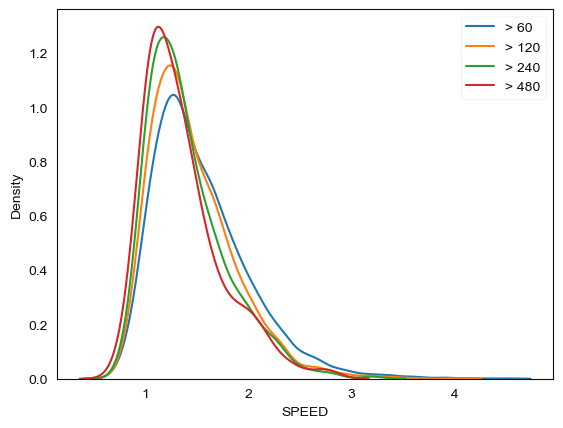

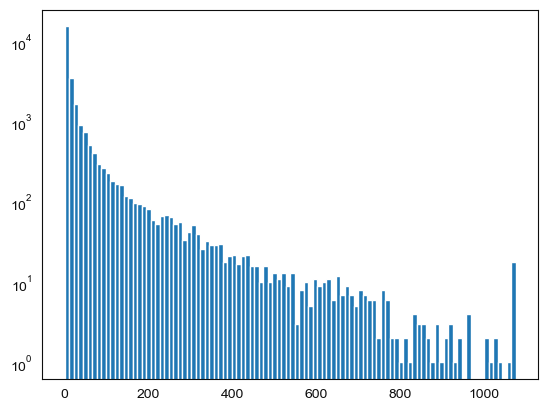

total 8h+ tracks: 284


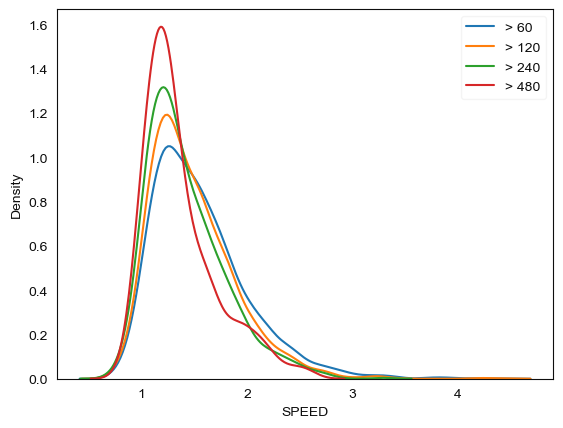

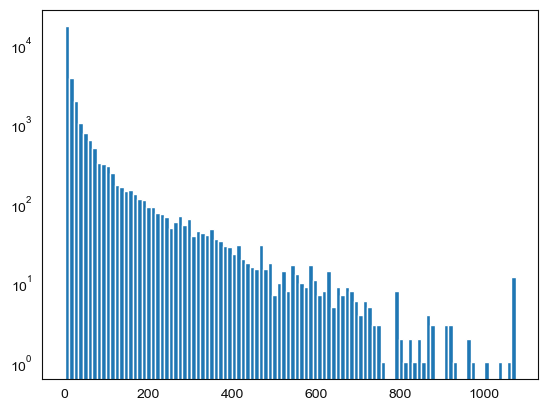

In [4]:
for root in roots:
    edges = r_edges[root]
    speeds = edges.groupby("TRACK_ID")["SPEED"].mean()
    lengths = edges.groupby("TRACK_ID")["TRACK_ID"].count()
    print(f"total 8h+ tracks: {len(lengths[lengths > 480])}")
    sns.kdeplot(speeds[lengths > 60], label="> 60")
    sns.kdeplot(speeds[lengths > 120], label="> 120")
    sns.kdeplot(speeds[lengths > 240], label="> 240")
    sns.kdeplot(speeds[lengths > 480], label="> 480")
    plt.legend()
    plt.show()
    
    # log plot of length distribution
    lengths.hist(bins=100)
    plt.yscale("log")
    plt.show()

In [ ]:
for root in roots:
    spots = r_spots[root]
    lengths = spots.groupby("TRACK_ID")["TRACK_ID"].count()
    long_tracks = lengths[lengths > 480].index
    long_spots = spots[spots["TRACK_ID"].isin(long_tracks)]
    long_spots = long_spots.sort_values("FRAME")
    for track in long_tracks:
        track_spots = long_spots[long_spots["TRACK_ID"] == track]
        # print(track_spots)
        plt.plot(track_spots["POSITION_X"], track_spots["POSITION_Y"], label=track)
    
    plt.show()
    
    for track in np.random.choice(long_tracks, 10):
        track_spots = long_spots[long_spots["TRACK_ID"] == track]
        plt.plot(track_spots["FRAME"], track_spots["MEAN_INTENSITY_CH2"], label=track)
        
    plt.legend()
    plt.show()

In [ ]:

import cv2

for root in roots:
    root_folder = Path(f"D:\\Tracking\\evan\\{root}")
    raw_path = root_folder / "raw.tif"
    label_path = root_folder / "masks.tif"

    folder = Path(r"D:\Tracking\evan")  

    raw = tifffile.imread(raw_path)
    labels = tifffile.imread(label_path)
    
    spots = r_spots[root]
    lengths = spots.groupby("TRACK_ID")["TRACK_ID"].count()
    long_tracks = lengths[lengths > 480].index
    long_spots = spots[spots["TRACK_ID"].isin(long_tracks)]
    long_spots = long_spots.sort_values("FRAME")
    
    for track in np.random.choice(long_tracks, 10):
        spot_subset = long_spots[long_spots["TRACK_ID"] == track]
        
        miny = max(round(spot_subset["POSITION_Y"].min() - 45), 0)
        maxy = min(round(spot_subset["POSITION_Y"].max() + 45), raw.shape[1])
        minx = max(round(spot_subset["POSITION_X"].min() - 45), 0)
        maxx = min(round(spot_subset["POSITION_X"].max() + 45), raw.shape[2])
        
        
        rawcrop = raw[:, miny:maxy, minx:maxx]
        labelcrop = labels[:, miny:maxy, minx:maxx]
        breakp = False

        
        out = []
        for frame in spot_subset["FRAME"]:
            label = round(spot_subset[spot_subset["FRAME"] == frame]["MEDIAN_INTENSITY_CH1"].values[0])
            binary = labelcrop[frame] == label
            contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            rgb = np.stack([rawcrop[frame]] * 3, axis=-1) / np.quantile(rawcrop[frame], 0.99)
            rgb = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
            try:
                cv2.drawContours(rgb, contours, -1, (255, 192, 203), 1)
            except:
                print(label, sum(binary.flatten()))
                breakp=True
                break
            out.append(rgb)
            
        if breakp:
            continue            
            
        out = np.stack(out)
        out = np.moveaxis(out, -1, 1)
        # write as rgb
        tifffile.imwrite(folder / f"track_vis/track{root}_{track}.tif", out, imagej=True, metadata={"axes": "TCYX", "mode": "composite"})


In [8]:
def hex_to_rgb(hex):
    hex = hex.lstrip("#")
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

In [9]:

import cv2
start = 660
end = 900

root = "2b"
root_folder = Path(f"D:\\Tracking\\evan\\{root}")
raw_path = root_folder / "raw.tif"
label_path = root_folder / "masks.tif"

folder = Path(r"D:\Tracking\evan")  

raw = tifffile.imread(raw_path)
labels = tifffile.imread(label_path)

spots = r_spots[root]
lengths = spots.groupby("TRACK_ID")["TRACK_ID"].count()
track_starts = spots.groupby("TRACK_ID")["FRAME"].min()
track_ends = spots.groupby("TRACK_ID")["FRAME"].max()
long_tracks = lengths[(track_starts <= start) & (track_ends > end)].index
long_spots = spots[spots["TRACK_ID"].isin(long_tracks)]
long_spots = long_spots.sort_values("FRAME")


out = []

for frame in tqdm(range(start, end)):
    raw_frame = raw[frame]
    label_frame = labels[frame]
    rgb = np.stack([raw_frame] * 3, axis=-1) / np.quantile(raw_frame, 0.99)
    rgb = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
    
    for i, track in enumerate(long_tracks):
        frame_spot_label = long_spots[(long_spots["TRACK_ID"] == track) & (long_spots["FRAME"] == frame)]
        if len(frame_spot_label) == 0:
            continue

        label = round(frame_spot_label["MEDIAN_INTENSITY_CH1"].values[0])

        binary = label_frame == label
        contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cv2.drawContours(rgb, contours, -1, hex_to_rgb(g_palette[i]), 2)
    
    out.append(rgb)

out = np.stack(out, dtype=np.uint8) 
out = np.moveaxis(out, -1, 1)
tifffile.imwrite(folder / f"movie_{root}_late.tif", out, imagej=True, metadata={"axes": "TCYX", "mode": "composite"})


100%|██████████| 240/240 [02:31<00:00,  1.58it/s]
